In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data = pd.read_csv('./Financial Well-Being Survey Data/NFWBS_PUF_2016_data.csv')

print(f'The dataset contains {data.shape[0]} rows and {data.shape[1]} features.')

The dataset contains 6394 rows and 217 features.


In [6]:
data.set_index('PUF_ID', inplace=True)

# Data exploration

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6394 entries, 10350 to 8516
Columns: 216 entries, sample to finalwt
dtypes: float64(2), int64(214)
memory usage: 10.6 MB


In [8]:
data.head()

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,FWB1_4,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
10350,2,3,5,5,6,55,3,3,3,3,...,1,4,8,0,0,0,0,1,0,0.367292
7740,1,3,6,6,6,51,2,2,3,3,...,1,2,3,0,0,0,0,2,0,1.327561
13699,1,3,4,3,4,49,3,3,3,3,...,1,4,9,0,0,0,1,2,1,0.835156
7267,1,3,6,6,6,49,3,3,3,3,...,1,3,7,0,0,0,0,1,0,1.410871
7375,1,3,4,4,4,49,3,3,3,3,...,1,2,4,0,0,1,0,4,1,4.260668


In [9]:
max(data.isna().sum()) # no explicit missing values

0

In [10]:
data.columns.values

array(['sample', 'fpl', 'SWB_1', 'SWB_2', 'SWB_3', 'FWBscore', 'FWB1_1',
       'FWB1_2', 'FWB1_3', 'FWB1_4', 'FWB1_5', 'FWB1_6', 'FWB2_1',
       'FWB2_2', 'FWB2_3', 'FWB2_4', 'FSscore', 'FS1_1', 'FS1_2', 'FS1_3',
       'FS1_4', 'FS1_5', 'FS1_6', 'FS1_7', 'FS2_1', 'FS2_2', 'FS2_3',
       'SUBKNOWL1', 'ACT1_1', 'ACT1_2', 'FINGOALS', 'PROPPLAN_1',
       'PROPPLAN_2', 'PROPPLAN_3', 'PROPPLAN_4', 'MANAGE1_1', 'MANAGE1_2',
       'MANAGE1_3', 'MANAGE1_4', 'SAVEHABIT', 'FRUGALITY', 'AUTOMATED_1',
       'AUTOMATED_2', 'ASK1_1', 'ASK1_2', 'SUBNUMERACY2', 'SUBNUMERACY1',
       'CHANGEABLE', 'GOALCONF', 'LMscore', 'FINKNOWL1', 'FINKNOWL2',
       'FINKNOWL3', 'FK1correct', 'FK2correct', 'FK3correct', 'KHscore',
       'KHKNOWL1', 'KHKNOWL2', 'KHKNOWL3', 'KHKNOWL4', 'KHKNOWL5',
       'KHKNOWL6', 'KHKNOWL7', 'KHKNOWL8', 'KHKNOWL9', 'KH1correct',
       'KH2correct', 'KH3correct', 'KH4correct', 'KH5correct',
       'KH6correct', 'KH7correct', 'KH8correct', 'KH9correct', 'ENDSMEET',
       'H

## Dropping irrelevant features

In [11]:
FWB_cols = list(filter(lambda x: 'FWB' in x, data.columns.values))
data.drop(FWB_cols[1:], axis = 1, inplace = True)

FS_cols = list(filter(lambda x: 'FS' in x, data.columns.values))
data.drop(FS_cols[1:], axis = 1, inplace = True)

LM_cols = list(filter(lambda x: 'FINKNOWL' in x, data.columns.values))
data.drop(LM_cols, axis = 1, inplace = True)

FKcorrect_cols = ['FK1correct', 'FK2correct', 'FK3correct']
data.drop(FKcorrect_cols, axis = 1, inplace = True)

KH_cols = list(filter(lambda x: 'KHKNOWL' in x, data.columns.values))
data.drop(KH_cols, axis = 1, inplace = True)

KHcorrect_cols = ['KH1correct', 'KH2correct', 'KH3correct', 'KH4correct', 'KH5correct', 'KH6correct', 'KH7correct', 'KH8correct', 'KH9correct']
data.drop(KHcorrect_cols, axis = 1, inplace = True)

OBJNUMcols = list(filter(lambda x: 'OBJNUMERACY' in x, data.columns.values))
data.drop(OBJNUMcols, axis = 1, inplace = True)

In [12]:
data.shape

(6394, 171)

## Missing data

- -5: County not known (Applies to PCTLT200FPL. County was not known for these respondents and details on the county-level degree of poverty could not be merged in for these cases.) ACTION: 395 rows

- -4: Response not written to the database due to error (SWB and FWB variables) ACTION: only one record -> drop (?)

- -3: Invalid response/ Incoherent data (SOCSEC2, SOCSEC3, KIDS) ACTION: 234 rows for SOCSEC + 1 row for KIDS_2 drop(?)

- -2: Question not asked because respondant not in item base (VALUERANGES, MORTGAGE, PAIDHELP, SOCSEC1, SOCSEC2, SOCSEC3, LIFEEXPECT and RETIRE). The respondent was correctly skipped over this item based on responses to previous questions or panel data on respondant age ACTION: ? pesquisar

- 8: I can’t recall (HSLOC) ACTION: 21 rows -> impute with mode (?)

- -1: Not answered/ Left blank (Applies to most items) ACTION: 2302 rows with missing data (impute; see how to impute each case specifically)


- 98: Don't know (HOUSERANGES, VALUERANGES, MORTGAGE, SAVINGSRANGES) ACTION: 514 rows -> impute

- 99: Prefer not to say (HOUSERANGES, VALUERANGES, MORTGAGE, SAVINGSRANGES,  EMPLOY: Analysis variable of EMPLOY1-9 -> if EMPLOY did not select any, it is a missing value) ACTION: 1466 rows -> impute

__-5: County not known__

PCTLT200FPL: percentage of people who live in the same county as the survey respondent who have an income that is below 200% of the federal poverty level

-5 when unkown county of the responded

395 rows

How to solve this?
- impute: The narrowest information we have about respondant's residence is the census division. If we imputed with the census division percentage of people with income below 200% of FPL, all imputed values would be 0. Instead, it would be better to use a KNNimputer: variables that possibly relate people that live in the same county: Census division (PPREG9), Household income (PPINCIMP), Education (PPEDUC), Age (agecat), Financial Hardship (MATHARDSHIP_1 - MATHARDSHIP_6)

In [13]:
nrows = data[data['PCTLT200FPL'].isna()].shape[0]
print(f'nr of rows with missing value: {nrows}')

nr of rows with missing value: 0


In [14]:
data = data.replace(-5, np.nan)

In [15]:
data['PCTLT200FPL'].value_counts()

0.0    4548
1.0    1451
Name: PCTLT200FPL, dtype: int64

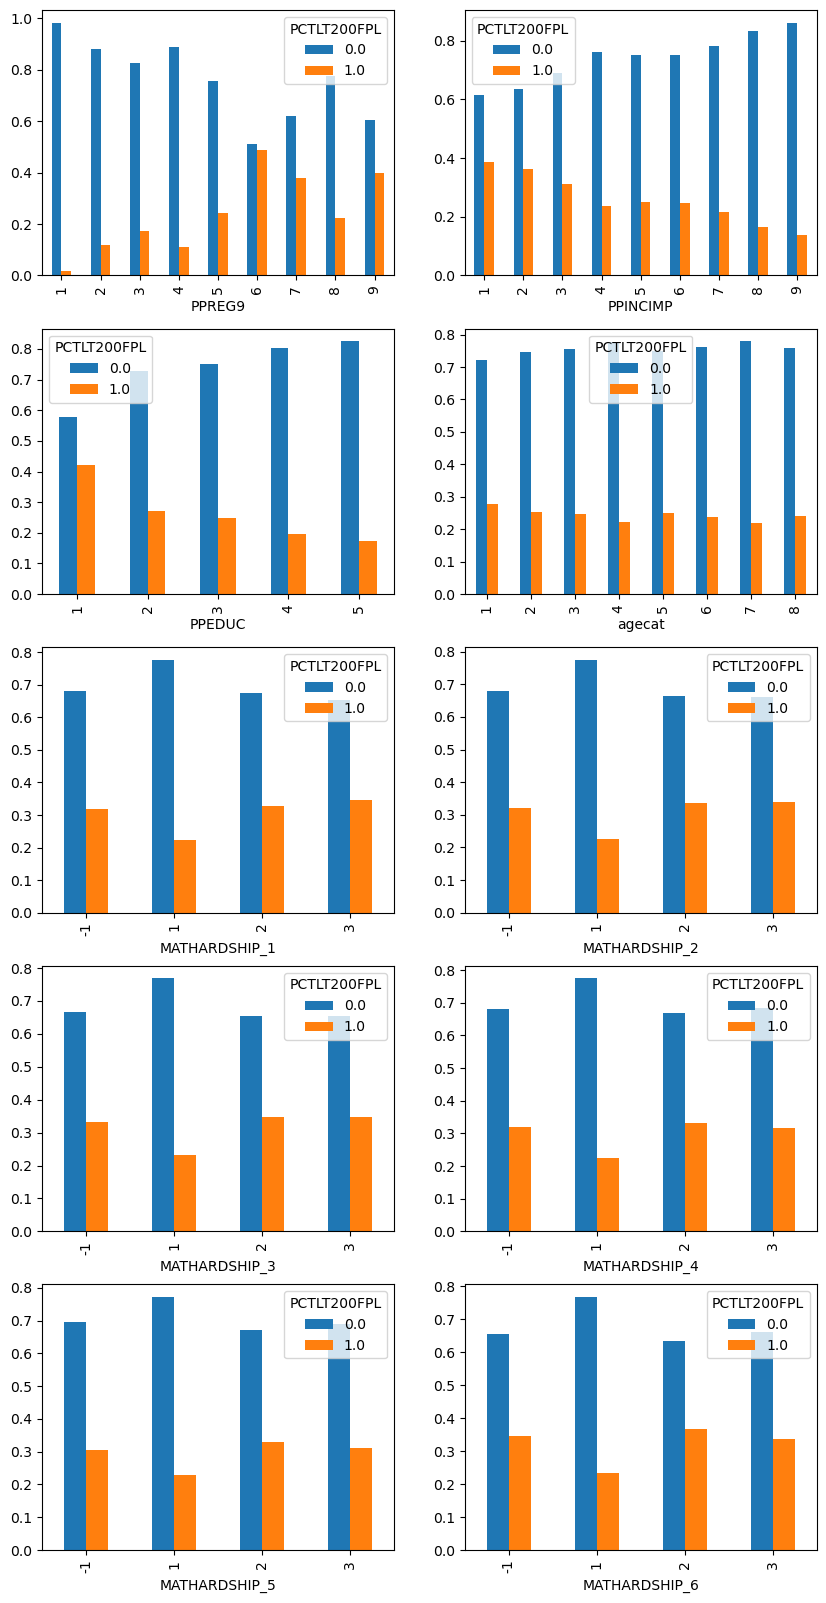

In [16]:
feats = ['PPREG9', 'PPINCIMP', 'PPEDUC', 'agecat', 'MATHARDSHIP_1', 'MATHARDSHIP_2', 'MATHARDSHIP_3', 'MATHARDSHIP_4', 'MATHARDSHIP_5', 'MATHARDSHIP_6']

fig, axs = plt.subplots(5, 2, figsize=(10, 20))
for i in range(1, 11):
    data.groupby(feats[i-1])['PCTLT200FPL'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

In [17]:
data = data.replace(np.nan, -5)

Conclusion: KNN using PPREG9, PPINCIMP and PPEDUC

__-4: Response not written to the database due to error__

SWB and FWB

How to solve this?
- drop: only one row affected

In [18]:
data[(data == -4).any(axis = 1)]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
12173,1,3,-4,-4,-4,-4,48,7,4,3,...,1,3,5,0,0,0,0,1,0.0,1.253964


In [19]:
data.drop(12173, inplace = True)

__-3: Invalid response/ Incoherent data__

SOCSEC2, SOCSEC3, KIDS_2

SOCSEC2: 'At what age did you begin receiving benefits'. Invalid when answered < 62 years

SOCSEC3: 'Age likely to start receiving Social Security retirement benefits'. Invalid when respondant age is two or more year greater than given response

KIDS_2 asks for the number of children of age between 7 to 12 that the respondent supports financially

235 rows with invalid data
- 166 from SOCSEC2
- 68 from SOCSEC3
- 1 from KIDS_2

What to do?
- set SOCSEC2 to -2 because response is invalid
- impute SOCSEC3 the same way as SOCSEC2
- drop KIDS_2

In [20]:
data[data['SOCSEC2'] == -3].shape[0]

166

In [21]:
data[data['SOCSEC3'] == -3].shape[0]

68

In [22]:
data[data['KIDS_2'] == -3].shape[0]

1

In [23]:
data = data.replace(-3, np.nan)

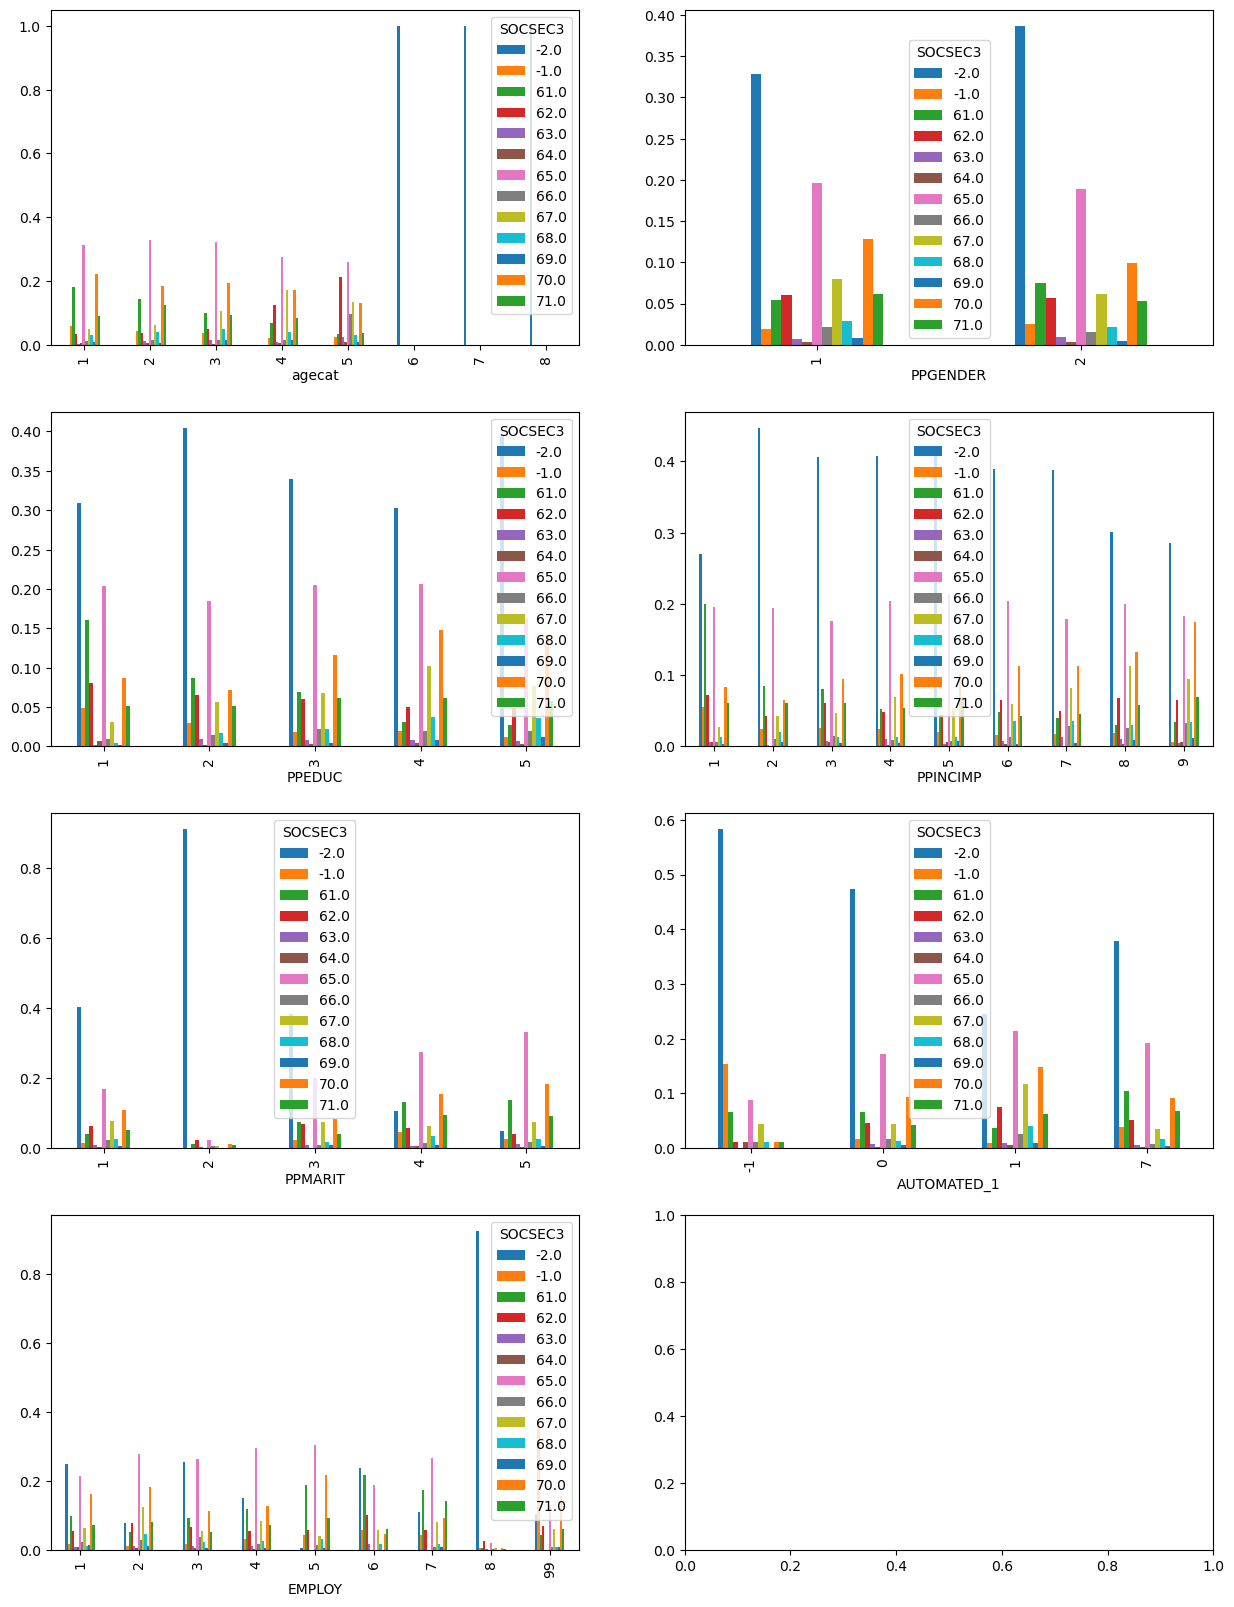

In [24]:
feats = ['agecat', 'PPGENDER', 'PPEDUC', 'PPINCIMP', 'PPMARIT', 'AUTOMATED_1', 'EMPLOY']

fig, axs = plt.subplots(4, 2, figsize=(15, 20))
for i in range(1, 8):
    data.groupby(feats[i-1])['SOCSEC3'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

No variable looks like distigushing well among likely age of SOCSEC3. Let's look at its distribution

<AxesSubplot:xlabel='SOCSEC3', ylabel='count'>

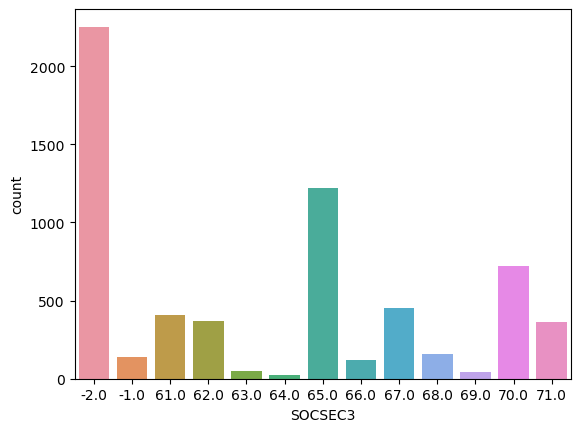

In [25]:
sns.countplot(x = 'SOCSEC3', data = data) # kinda normal distributed. Let's impute with the mode

In [26]:
data = data.replace(np.nan, -3)

__-2: Question not asked because respondant not in item base__

What to do?
- search!!!

In [27]:
data[(data == -2).any(axis = 1)]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
10350,2,3,5,5,6,55,44,5,4,3,...,1,4,8,0,0,0,0,1,0.0,0.367292
7740,1,3,6,6,6,51,43,5,4,3,...,1,2,3,0,0,0,0,2,0.0,1.327561
13699,1,3,4,3,4,49,42,5,3,3,...,1,4,9,0,0,0,1,2,1.0,0.835156
7267,1,3,6,6,6,49,42,-1,-1,-1,...,1,3,7,0,0,0,0,1,0.0,1.410871
7375,1,3,4,4,4,49,42,4,3,3,...,1,2,4,0,0,1,0,4,1.0,4.260668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11220,3,3,6,7,7,61,47,5,5,4,...,1,2,3,0,0,0,1,2,-5.0,0.522504
13118,3,2,7,7,7,59,59,6,4,4,...,1,3,6,0,0,0,0,3,-5.0,1.015219
8709,1,3,5,6,6,59,51,4,4,4,...,1,1,2,0,0,0,0,2,0.0,1.136270


__8: I can't recall__

HSLOC: Where respondent attended high school
- 1: US and territories
- 2: Outside the US
- 8: Can't recall

What do to?
- impute with mode

In [28]:
data['HSLOC'].value_counts()

 1    5386
-1     644
 2     342
 8      21
Name: HSLOC, dtype: int64

__-1: Not answered/ Left blank__

2301 rows

__98: Don't know__

514 rows

__99: Prefer not to say__


1384 rows in total

- 624 from HOUSERANGES
- 159 from VALUERANGES
- 498 from MORTGAGE
- 988 from SAVINGSRANGES
- 116 from EMPLOY



What to do?
- SWB: median
- SUBKNOWL1: median
- ACT: KNNImputerMode
- FINGOALS: KNNImputerMode
- PROPLAN: drop
- MANAGE: mode + knn
- SAVEHABIT: KNNImputerMode
- FRUGALITY: mode
- AUTOMATED: KNNImputerMode
- ASK: KNNImputerMode + mode
- SUBNUMERACY: KNNImputerMode + mode
- CHANGEABLE: mode
- GOALCONF: KNNImputerMode
- ENDSMEET: KNNImputerMode
- HOUSING:
- LIVINGARRANGEMENT:
<br>
- HOUSERANGES:
- VALUERANGES:
- MORTGAGE:
- SAVINGSRANGES:
<br>
- CONSPROTECT:
- EARNERS:
- VOLATILITY:
- SNAP:
- MATHARDSHIP:
- COLLECT:
- REJECTED:
- ABSORBSHOCK:
- BENEFITS:
- FRAUD2:
- COVERCOSTS:
- BORROW:
- MANAGE2:
- PAIDHELP:
- HSLOC:
- PAREDUC:
- FINSOC:
- MATERIALISM:
- CONNECT:
- HEALTH:
- SCFHORIZON:
- DISCOUNT:
- MEMLOSS:
- DISTRESS:
- SELFCONTROL:
- OUTLOOK:
- PEM:
- HOUSESAT:
- SOCSEC:
- LIFEEXPECT:
- HHEDUC:
- KIDS:
<br>
- EMPLOY
<br>
- RETIRE:
- MILITARY:
- Military_Status:

In [29]:
data[(data == -1).any(axis = 1)].shape[0]

2244

In [30]:
data[(data[['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES']] == 98).any(axis = 1)].shape[0]

514

In [31]:
data[(data[['HOUSERANGES', 'VALUERANGES', 'MORTGAGE', 'SAVINGSRANGES']] == 99).any(axis = 1)].shape[0]

1384

In [32]:
data = data.replace(-1, np.nan)
data = data.replace(98, np.nan)
data = data.replace(99, np.nan)

Let's see the number of missing values per row to try to exclude rows with too many missing values

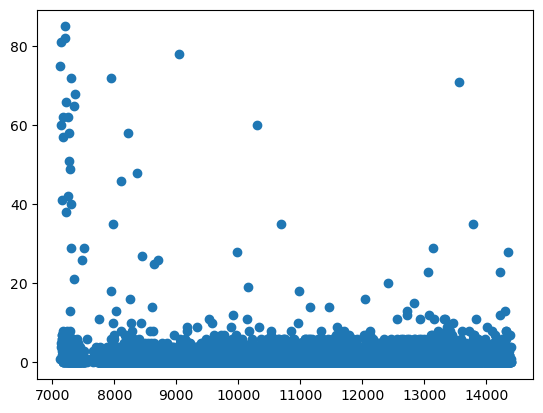

In [33]:
plt.scatter(data.isna().sum(axis = 1).index, data.isna().sum(axis = 1))

There are 171 columns, so any row with more than 5 missing values will be excluded

In [34]:
data[data.isna().sum(axis = 1) >= 5]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
7267,1,3,6.0,6.0,6.0,49.0,42.0,NaN,NaN,NaN,...,1,3,7,0,0,0,0,1,0.0,1.410871
8303,1,3,7.0,7.0,7.0,43.0,58.0,4.0,3.0,3.0,...,1,3,7,0,0,0,1,3,0.0,2.497838
9182,1,3,6.0,NaN,NaN,50.0,43.0,4.0,4.0,3.0,...,1,4,9,0,0,0,0,2,0.0,0.647301
11082,1,3,6.0,6.0,5.0,62.0,55.0,4.0,5.0,4.0,...,1,3,5,0,0,0,0,3,0.0,0.455829
8309,2,3,3.0,4.0,2.0,49.0,37.0,NaN,4.0,3.0,...,1,3,5,0,0,0,0,1,0.0,0.597089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11078,3,1,3.0,4.0,5.0,26.0,44.0,4.0,3.0,3.0,...,1,2,3,0,1,0,0,1,-5.0,1.379959
12353,1,3,5.0,7.0,3.0,62.0,26.0,4.0,3.0,3.0,...,1,3,5,0,0,0,0,2,0.0,1.745759
12297,3,3,4.0,5.0,7.0,55.0,45.0,5.0,4.0,3.0,...,1,2,4,0,0,0,1,2,-5.0,0.883213


In [35]:
data.drop(data[data.isna().sum(axis = 1) >= 5].index, axis = 0, inplace = True)

In [36]:
data.shape

(6026, 171)

Only 367 rows will be excluded

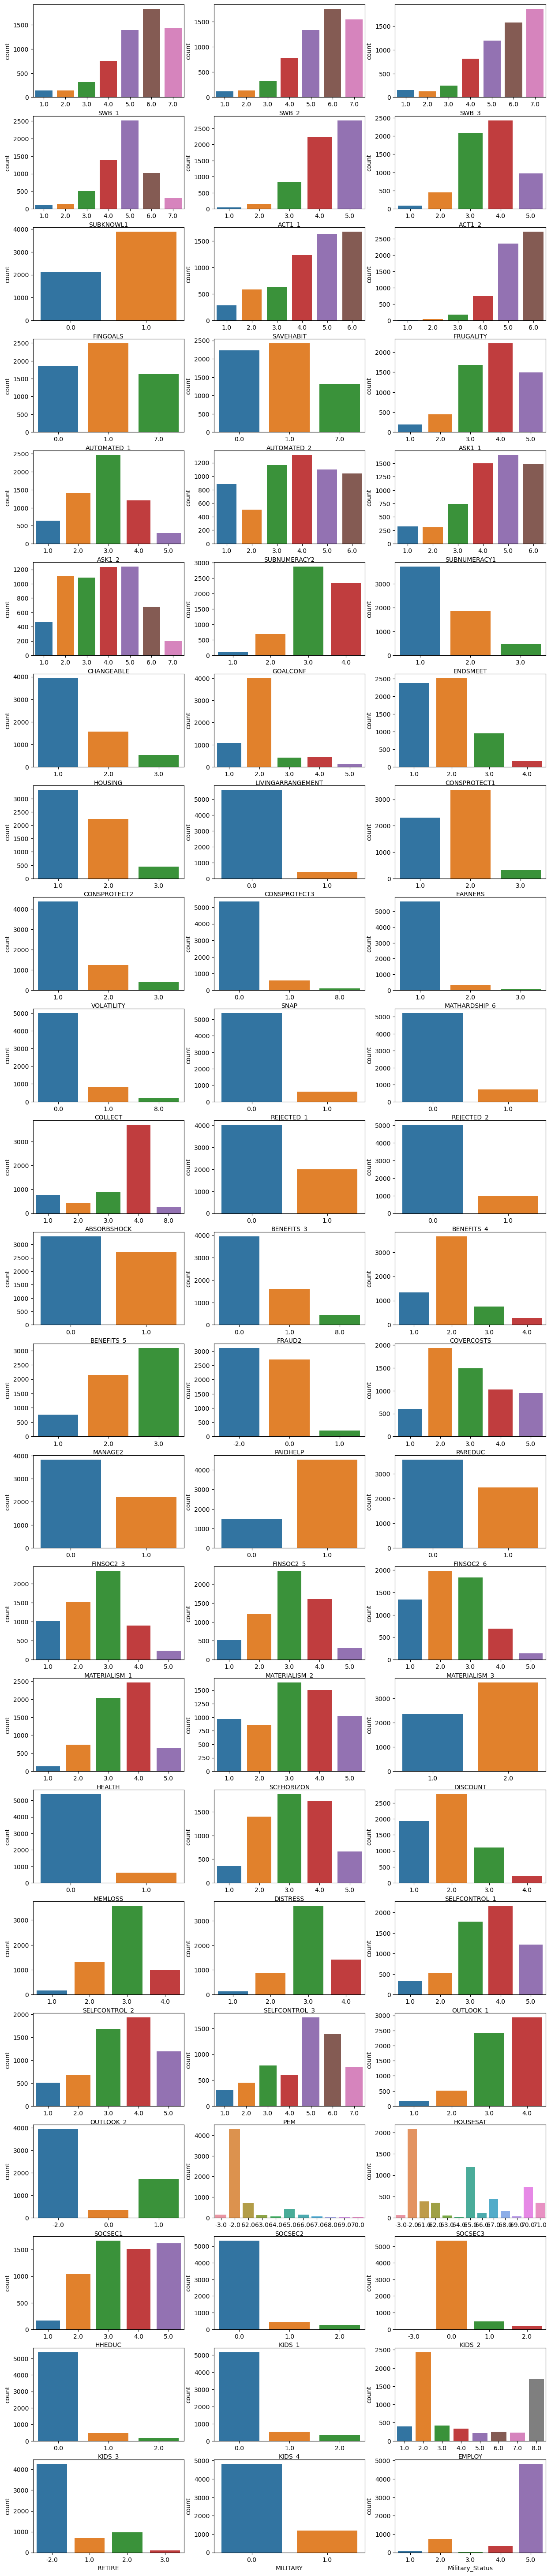

In [37]:
cols = ['SWB_1', 'SWB_2', 'SWB_3', 'SUBKNOWL1', 'ACT1_1', 'ACT1_2', 'FINGOALS',
'SAVEHABIT', 'FRUGALITY', 'AUTOMATED_1', 'AUTOMATED_2', 'ASK1_1',
'ASK1_2', 'SUBNUMERACY2', 'SUBNUMERACY1', 'CHANGEABLE', 'GOALCONF',
'ENDSMEET', 'HOUSING', 'LIVINGARRANGEMENT', 'CONSPROTECT1',
'CONSPROTECT2', 'CONSPROTECT3', 'EARNERS', 'VOLATILITY', 'SNAP',
'MATHARDSHIP_6', 'COLLECT', 'REJECTED_1', 'REJECTED_2', 'ABSORBSHOCK',
'BENEFITS_3', 'BENEFITS_4', 'BENEFITS_5', 'FRAUD2', 'COVERCOSTS',
'MANAGE2', 'PAIDHELP', 'PAREDUC', 'FINSOC2_3', 'FINSOC2_5', 'FINSOC2_6',
'MATERIALISM_1', 'MATERIALISM_2', 'MATERIALISM_3', 'HEALTH',
'SCFHORIZON', 'DISCOUNT', 'MEMLOSS', 'DISTRESS', 'SELFCONTROL_1',
'SELFCONTROL_2', 'SELFCONTROL_3', 'OUTLOOK_1', 'OUTLOOK_2', 'PEM',
'HOUSESAT', 'SOCSEC1', 'SOCSEC2', 'SOCSEC3', 'HHEDUC', 'KIDS_1',
'KIDS_2', 'KIDS_3', 'KIDS_4', 'EMPLOY', 'RETIRE', 'MILITARY',
'Military_Status']

fig, axs = plt.subplots(23, 3, figsize=(15, 75))

for i in range(1, 70):
    # sns countplot on axis
    sns.countplot(x = cols[i - 1], data = data, ax = axs[(i - 1 )// 3, (i-1) % 3])

SWB_1, SWB_2, SUBKNOWL1, ACT1_2, ASK1_1, SUBNUMERACY1, LIVINGARRANGEMENT, CONSPROTECT1, ABSORBSHOCK, PAREDUC, MATERIALISM_3, HEALTH, SELFCONTROL_1, SELFCONTROL_2, SELFCONTROL_3, OUTLOOK_1, OUTLOOK_2, PEM: skewed -> median

SWB_3, ACT1_1, SAVEHABIT, FRUGALITY, ENDSMEET, CONSPROTECT2, MATHARDSHIP_6, HOUSESAT: staricase -> mode

AUTOMATED_1, AUTOMATED_2, ASK1_2, SUBNUMERACY2, CHANGEABLE, GOALCONF, EARNERS, MATERIALISM,_1, MATERIALISM_2, SCFHORIZON, DISTRESS, HHEDUC, EMPLOY, RETIRE (cuidado com -2): gaussian distribution -> mode

Categorical:

FINGOALS, AUTOMATED_2, HOUSING, CONSPROTECT3, VOLATILITY, SNAP, COLLECT, REJECTED_1, REJECTED_2, BENEFITS_3, BENEFITS_4, BENEFITS_5, FRAUD2, COVERCOSTS, MANAGE2, PAIDHELP (cuidado com -2), FINSOC2_3, FINSOC2_5, FINSOC2_6, DISCOUNT, MEMLOSS, SOCSEC1, SOCSEC2, SOCSEC3 (cuidado com -3 e -2), KIDS_1, KIDS_2, KIDS_3, KIDS_4, EMPLOY, MILITARY, Military_Status: mode

Mode imputation: This involves replacing the missing values with the most frequent value in the ordinal feature. This method is most appropriate when the feature is niminal or when it is ordinal and has a few missing values

Median imputation: This involves replacing the missing values with the median value of the ordinal feature. This method is most appropriate when the ordinal feature has a skewed distribution.

__HOUSERANGES__

'About how much do you pay for your home each month?'

Possibly related variables: FWBScore, PROPPLAN_3, MANAGE1_3, SAVEHABIT, GOALCONF, ENDSMEET, HOUSING, LIVINGARRANGEMENTS, PRODHAVE_1, ERANERS, VOLATILITY, MATHARDSHIP_3, COLLECT, ABSORBSHOCK

<AxesSubplot:xlabel='HOUSERANGES', ylabel='count'>

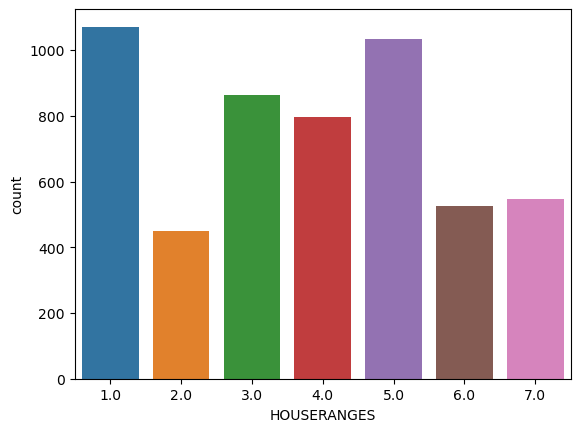

In [38]:
sns.countplot(x = 'HOUSERANGES', data = data)

In [39]:
data['HOUSERANGES'].value_counts()

1.0    1071
5.0    1035
3.0     862
4.0     797
7.0     548
6.0     527
2.0     449
Name: HOUSERANGES, dtype: int64

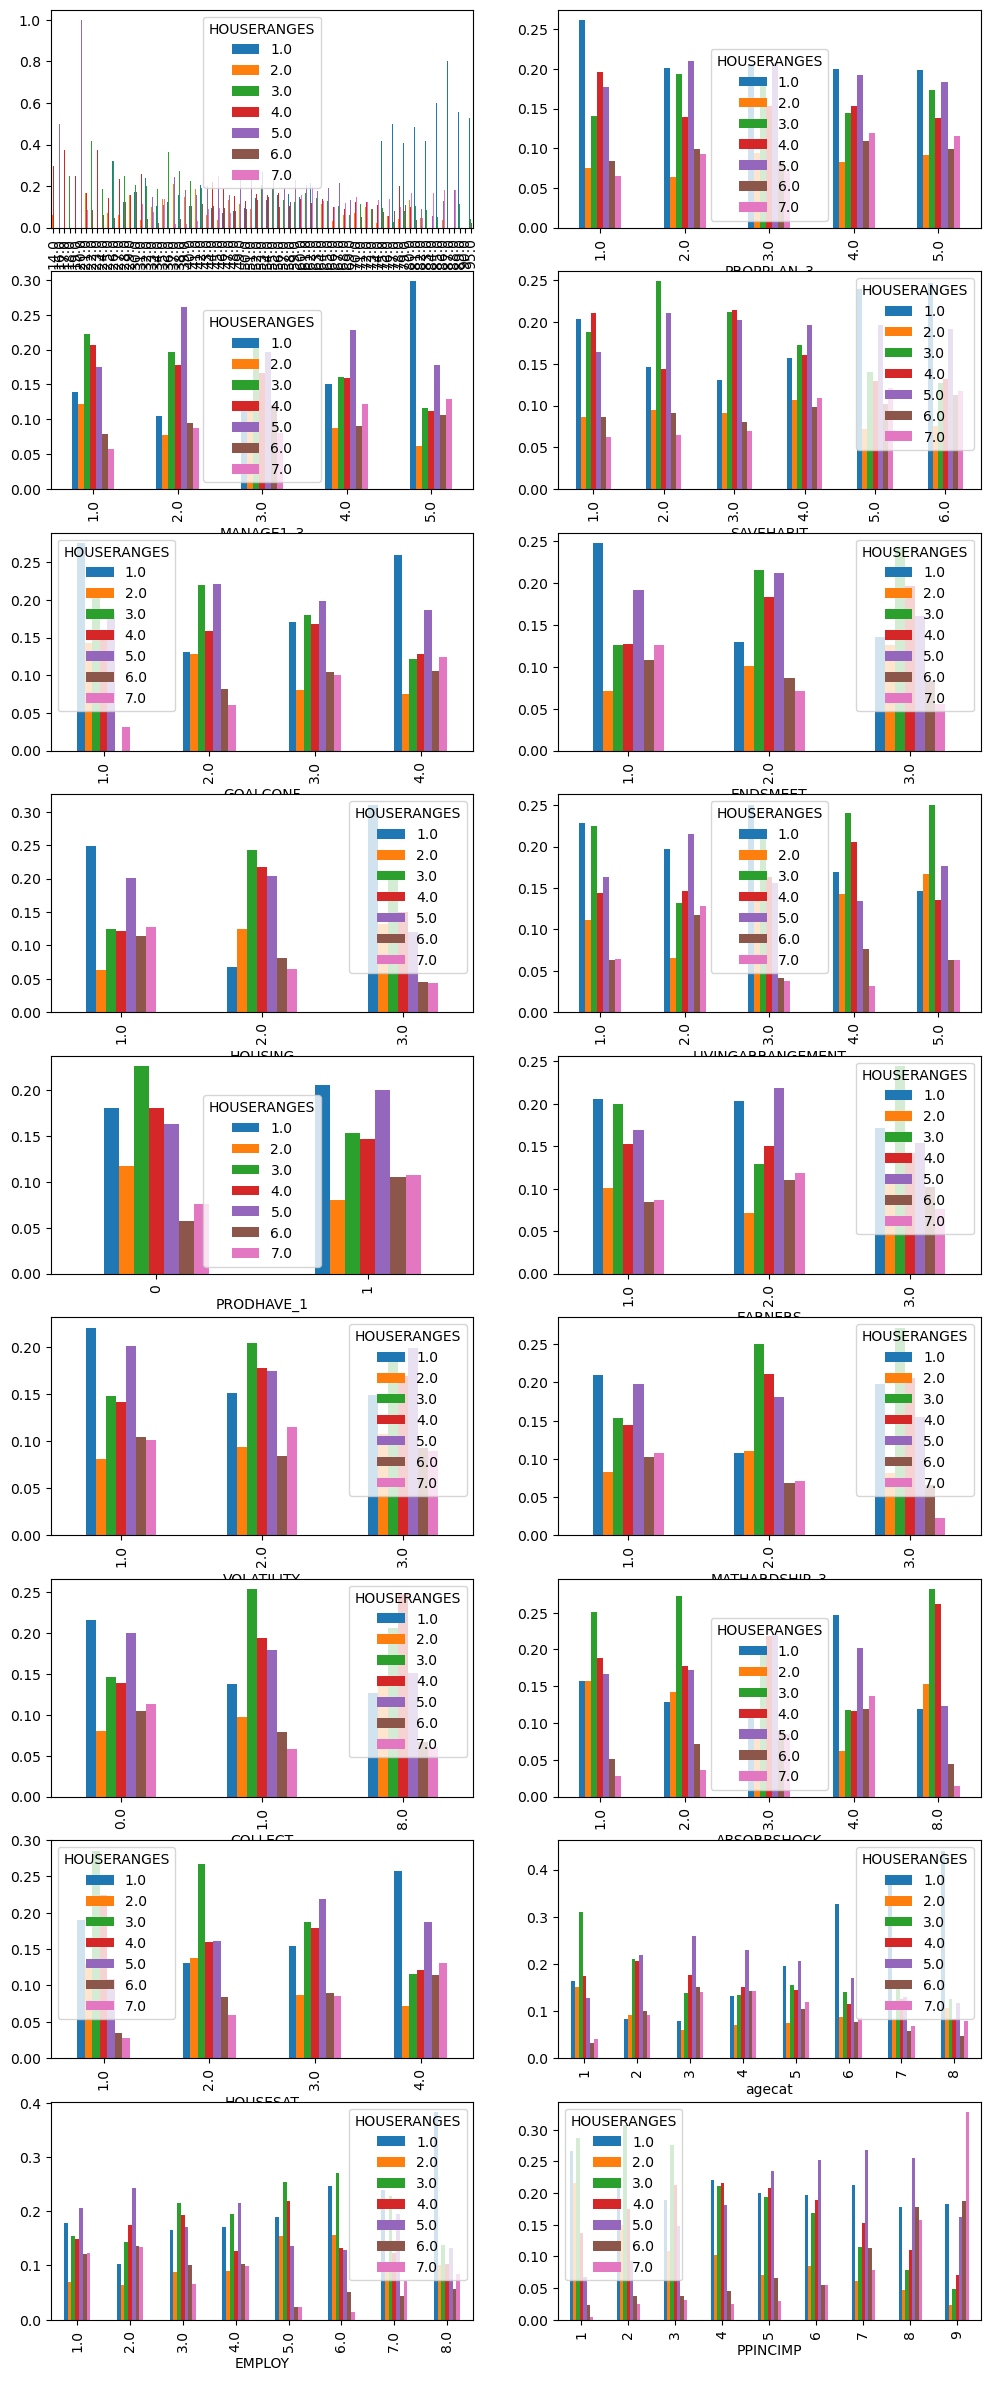

In [40]:
fig, axs = plt.subplots(9, 2, figsize=(12, 30))

feats = ['FWBscore', 'PROPPLAN_3', 'MANAGE1_3', 'SAVEHABIT', 'GOALCONF', 'ENDSMEET', 'HOUSING', 'LIVINGARRANGEMENT', 'PRODHAVE_1', 'EARNERS', 'VOLATILITY', 'MATHARDSHIP_3', 'COLLECT', 'ABSORBSHOCK', 'HOUSESAT', 'agecat', 'EMPLOY', 'PPINCIMP']
for i in range(1, 19):
    data.groupby(feats[i - 1])['HOUSERANGES'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

Best variables: FWBscore, COLLECT, ABSORBSCHOCK, HOUSING, GOALCONF, MANAGE1_3, ENDSMEET, SAVEHABIT, HOUSESAT, PPINCMP

#TODO: rever

__VALUERANGES__

'If you were to sell your home today, what do you think it would be worth?'

Possibly related variables: HOUSERANGES, MATHARDSHIP_3, COLLECT, REJECTED_1, REJECTED_2, MANAGE2, HOUSESAT, HOUSING, PPHHSIZE, PPINCIMP

In [41]:
data[data['VALUERANGES'].isna()].shape[0]

168

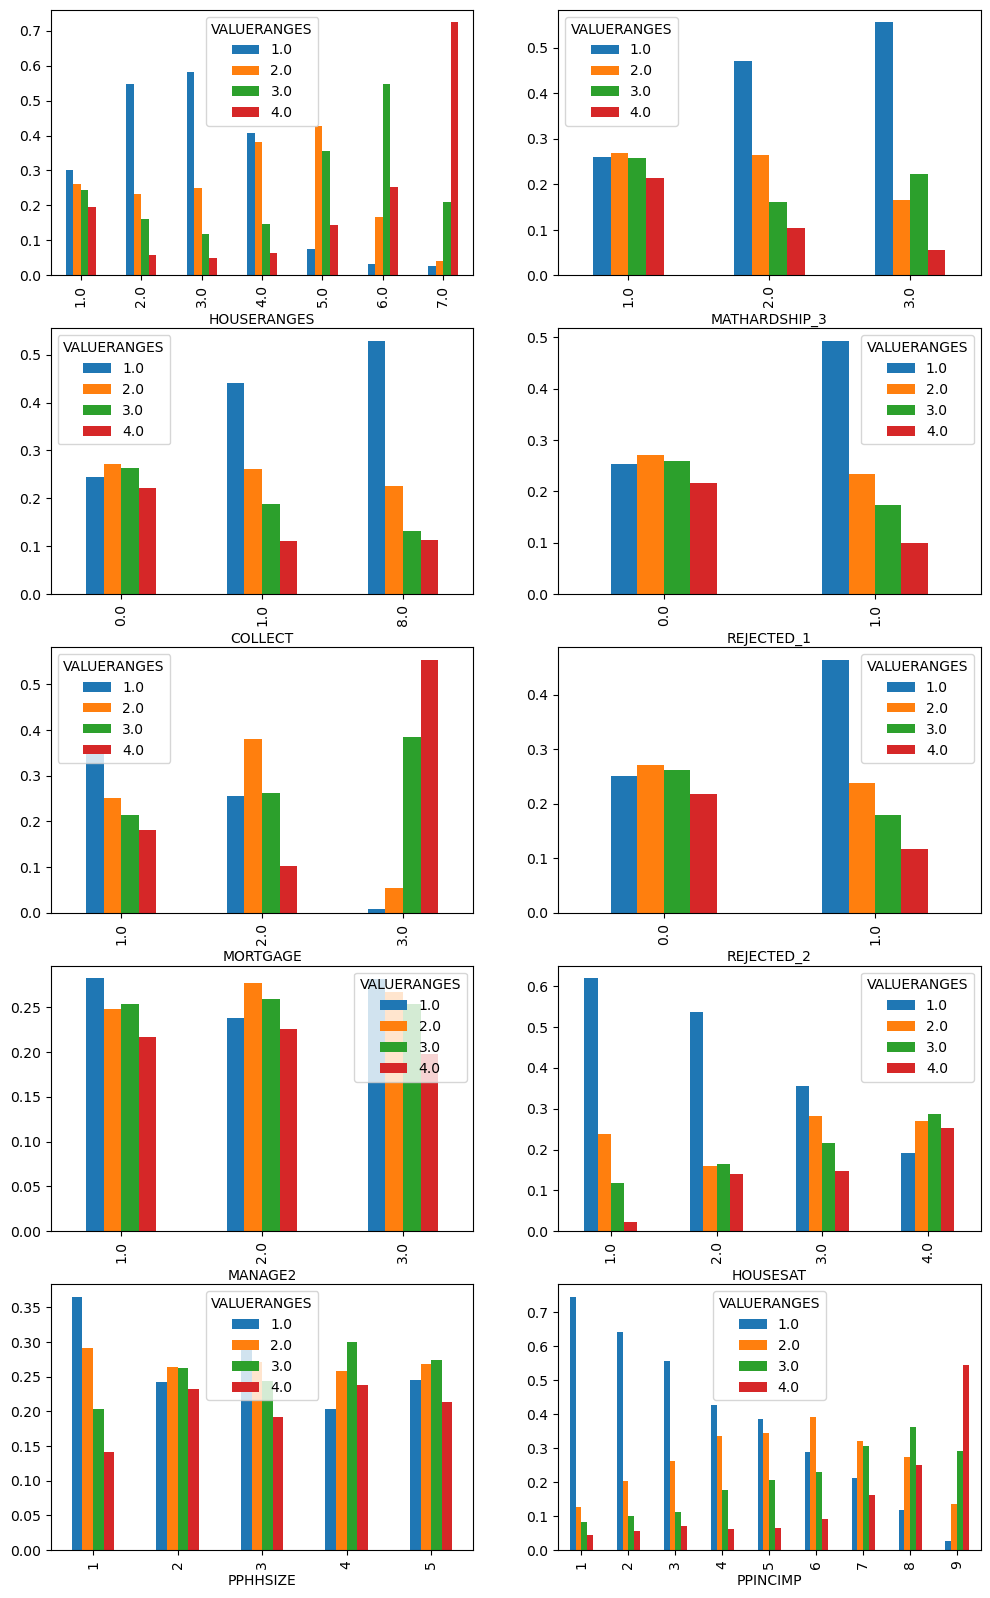

In [44]:
valid_data = data[data['VALUERANGES'] != -2]

fig, axs = plt.subplots(5, 2, figsize=(12, 20))

feats = ['HOUSERANGES', 'MATHARDSHIP_3', 'COLLECT', 'REJECTED_1', 'MORTGAGE', 'REJECTED_2', 'MANAGE2', 'HOUSESAT', 'PPHHSIZE', 'PPINCIMP']
for i in range(1, 11):
    valid_data.groupby(feats[i - 1])['VALUERANGES'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

<AxesSubplot:xlabel='VALUERANGES', ylabel='count'>

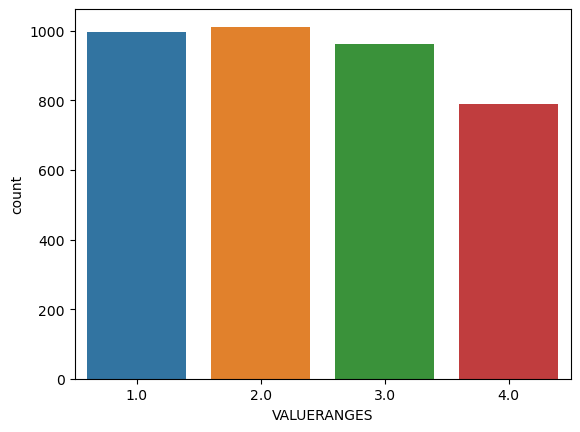

In [ ]:
sns.countplot(x = 'VALUERANGES', data = valid_data)

Best variables: HOUSERANGES, HOUSESAT, PPINCIMP

__MORTGAGE__

Similarly to VALUERANGES, the variables that are possibly correlated with the target variable are: HOUSERANGES, MATHARDSHIP_3, COLLECT, REJECTED_1, REJECTED_2, MANAGE2, HOUSESAT, PPHHSIZE and PPINCIMP

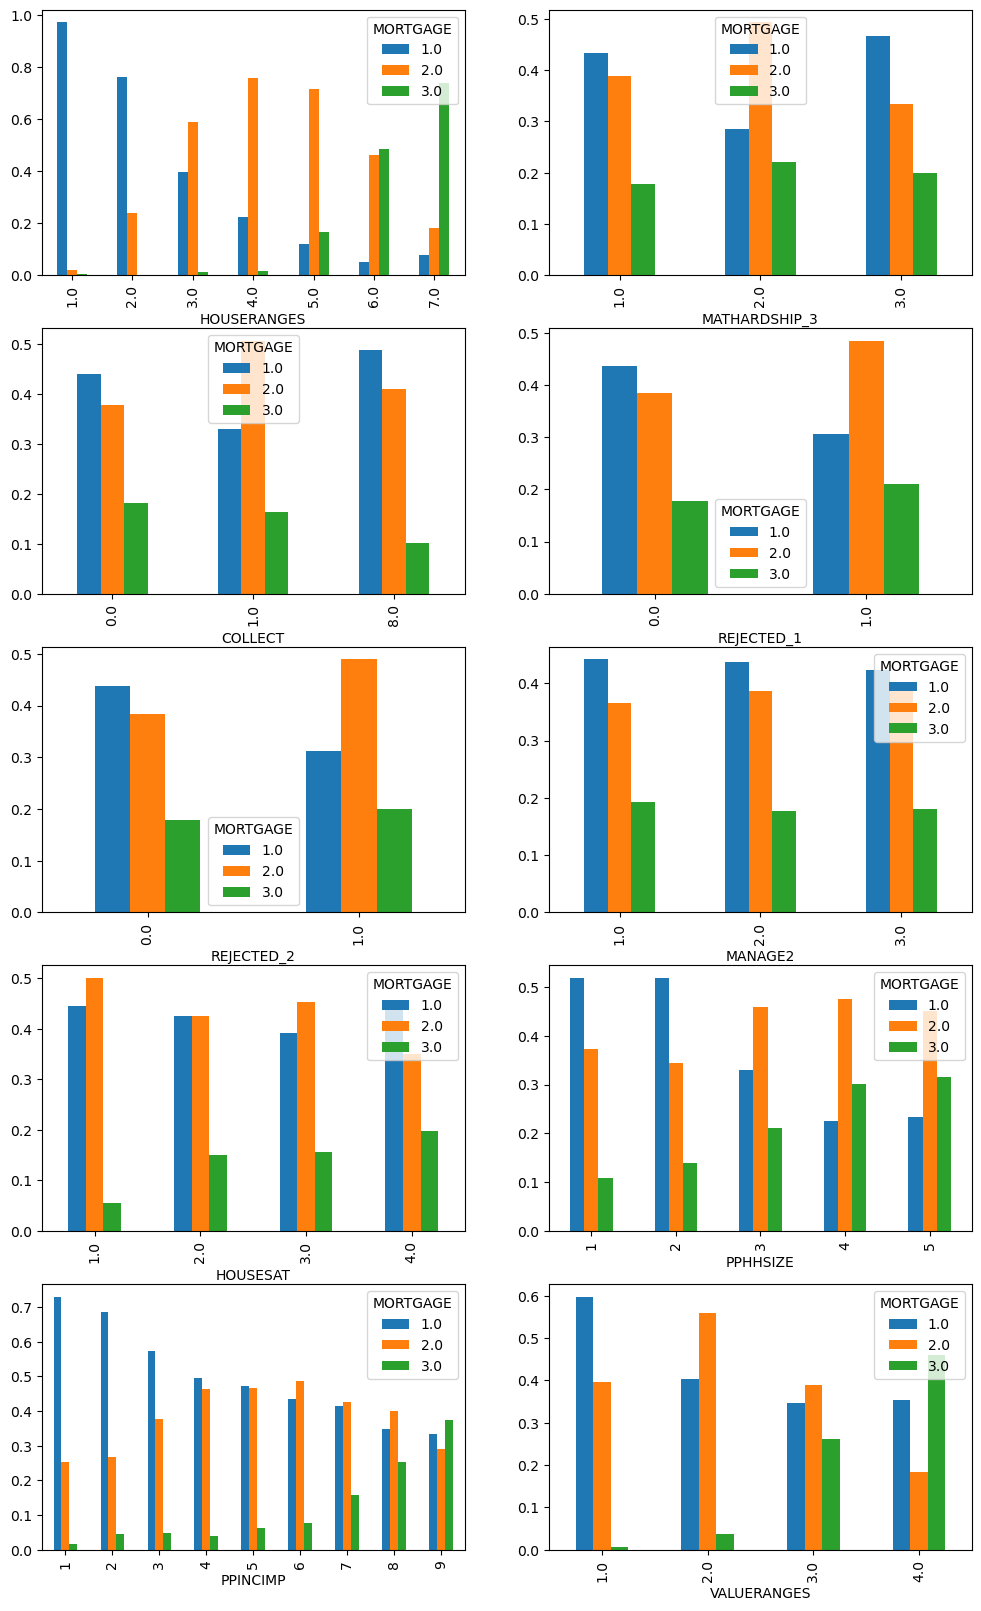

In [45]:
valid_data = data[data['MORTGAGE'] != -2]

fig, axs = plt.subplots(5, 2, figsize=(12, 20))

feats = ['HOUSERANGES', 'MATHARDSHIP_3', 'COLLECT', 'REJECTED_1', 'REJECTED_2', 'MANAGE2', 'HOUSESAT', 'PPHHSIZE', 'PPINCIMP', 'VALUERANGES']
for i in range(1, 11):
    valid_data.groupby(feats[i - 1])['MORTGAGE'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

Best variables: HOUSERANGES, PPHHSIZE, PPINCIMP

<AxesSubplot:xlabel='MORTGAGE', ylabel='count'>

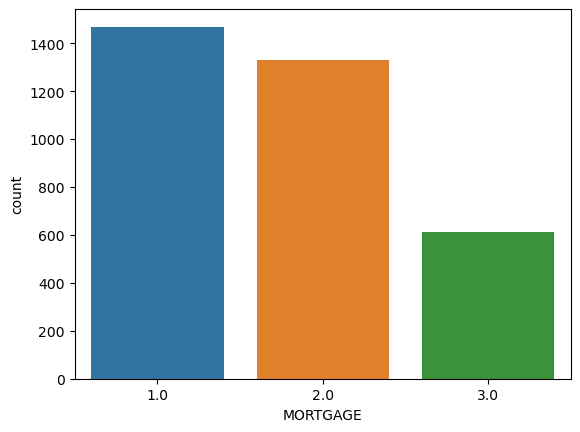

In [ ]:
sns.countplot(x = 'MORTGAGE', data = valid_data)

__SAVINGSRANGES__

'How much do you have in savings today?'

Possibly related variables: SAVEHABIT, AUTOMATED_1, AUTOMATED_2, PRODHAVE_1, PRODHAVE_7, BENEFITS_2, FINSOC2_2, FINSOC2_7, MATHARDSHIP_1, COLLECT, PPINCIMP

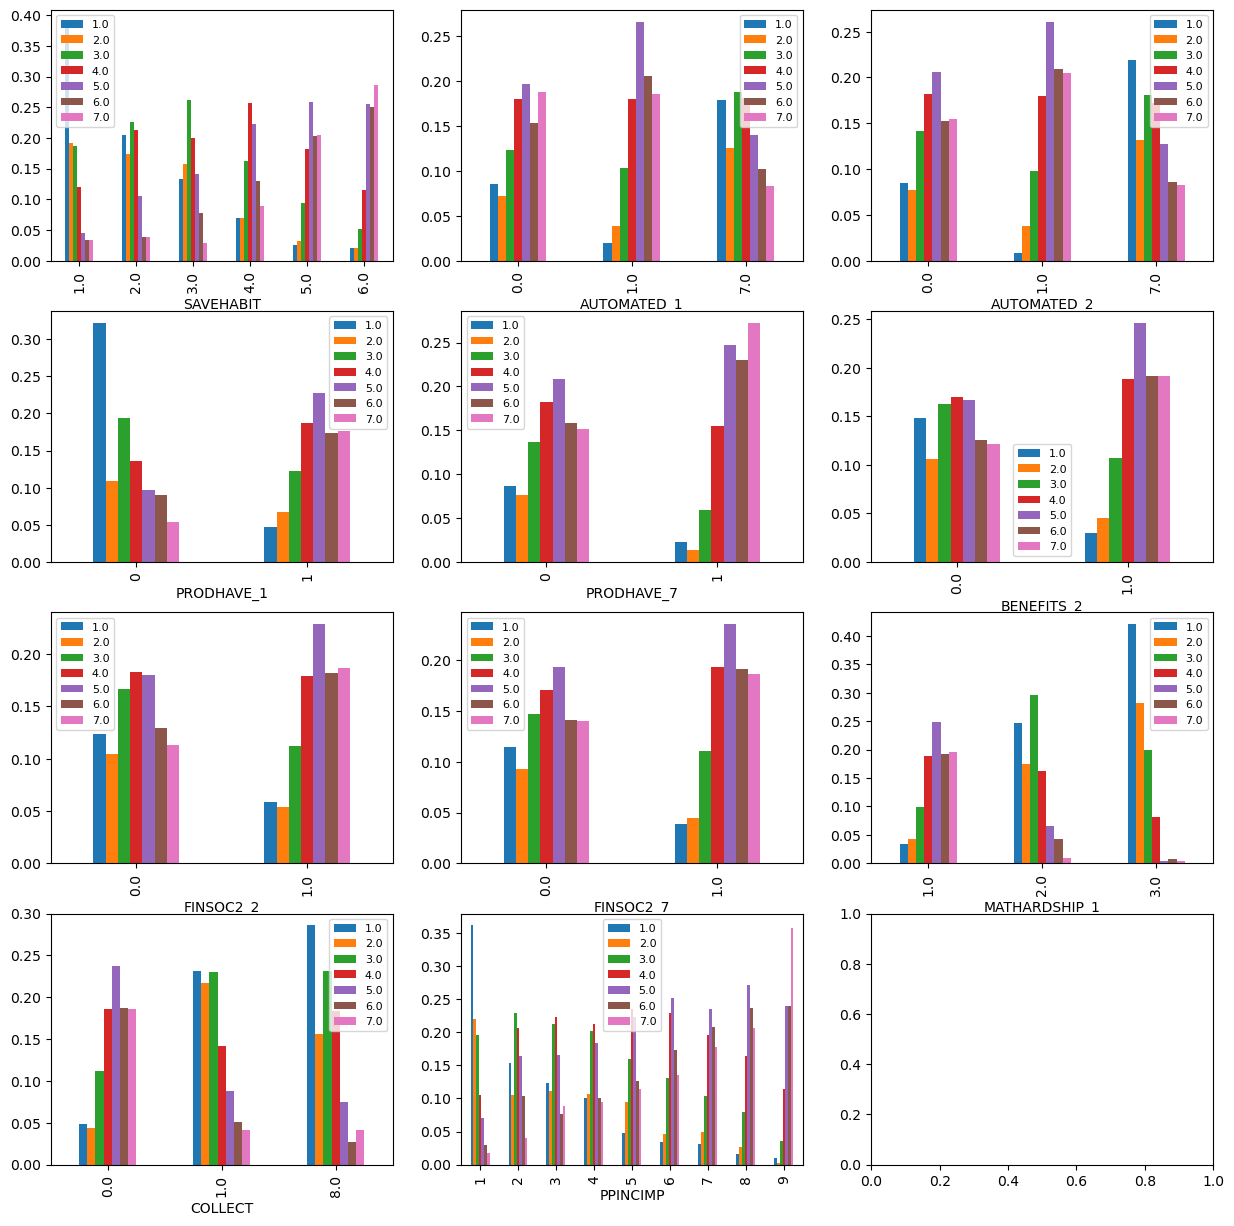

In [ ]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

feats = ['SAVEHABIT', 'AUTOMATED_1', 'AUTOMATED_2', 'PRODHAVE_1', 'PRODHAVE_7', 'BENEFITS_2', 'FINSOC2_2', 'FINSOC2_7', 'MATHARDSHIP_1', 'COLLECT', 'PPINCIMP']

for i in range(1, 12):
    data.groupby(feats[i - 1])['SAVINGSRANGES'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 3, (i-1) % 3])

    # set SAVINGSRANGES legend size
    axs[(i - 1 )// 3, (i-1) % 3].legend(fontsize = 8)

Best variables: SAVEHABIT, PRODHAVE_1, MATHARDSHIP_1, COLLECT, PPINCIMP

__BORROW_1 and BORROW_2__

<AxesSubplot:xlabel='BORROW_1', ylabel='count'>

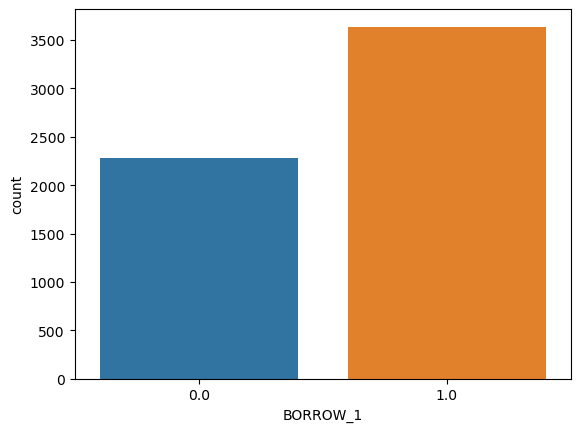

In [ ]:
sns.countplot(x = 'BORROW_1', data = data)

<AxesSubplot:xlabel='BORROW_2', ylabel='count'>

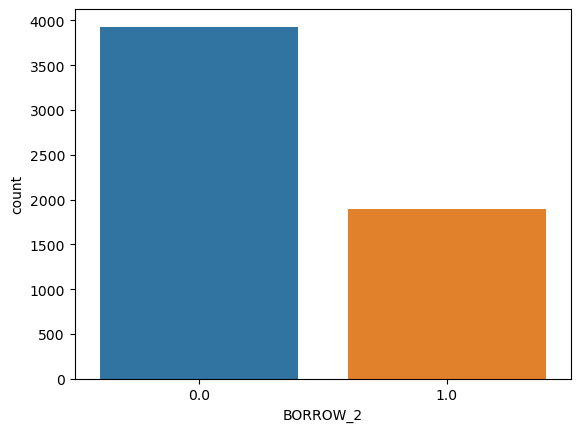

In [ ]:
sns.countplot(x = 'BORROW_2', data = data)

As it is difficult to find variables that are related to this one, the best way to impute the missing values is by using the mode

__HSLOC__

<AxesSubplot:xlabel='HSLOC', ylabel='count'>

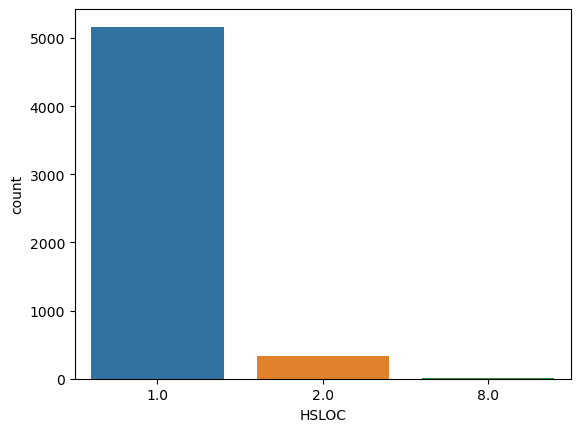

In [ ]:
sns.countplot(x = 'HSLOC', data = data)

This variable is really skewed, so its also better t «o just impute the missing values using the mode

__CONNECT__

0 means “I will be completely different in the future”
<br> 100 means “I will be exactly the same in the future.”

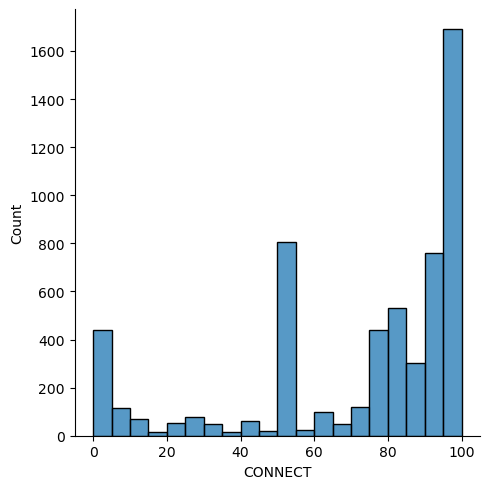

In [ ]:
sns.displot(x = 'CONNECT', data = data)

In [ ]:
data[data['CONNECT'] > 95].shape[0]

1375

Possibly related variables: CHANGEABLE, agecat, DISTRESS, PPINCIMP

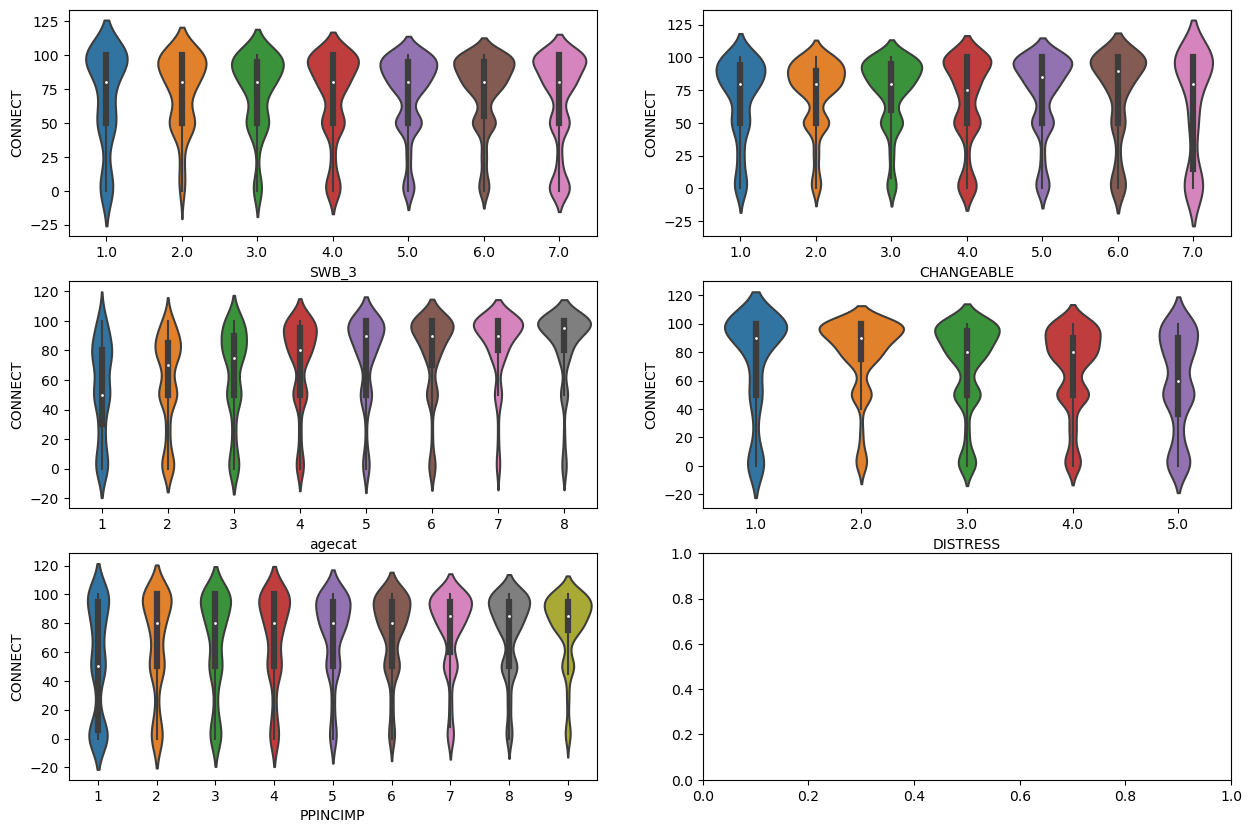

In [49]:
fig, axs = plt.subplots(3, 2, figsize=(15,10))

feats = ['SWB_3', 'CHANGEABLE', 'agecat', 'DISTRESS', 'PPINCIMP']

for i in range(1, 6):
    sns.violinplot(y = 'CONNECT', x = feats[i - 1], data = data, ax = axs[(i - 1 )// 2, (i-1) % 2])
    # data.groupby(feats[i - 1])['CONNECT'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

Best variables: PPINCIMP, DISTRESS, agecat, CHANGEABLE

__LIFEEEXPECT__

Possibly related variables: PRODHAVE_3, HEALTH, SHOCKS_5, agecat, SWB_2, DISTRESS

In [59]:
data[data['LIFEEXPECT'] != -2]

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FSscore,SUBKNOWL1,ACT1_1,ACT1_2,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
PUF_ID,,,,,,,,,,,,,,,,,,,,,
7740,1,3,6.0,6.0,6.0,51.0,43.0,5.0,4.0,3.0,...,1,2,3,0,0,0,0,2,0.0,1.327561
13699,1,3,4.0,3.0,4.0,49.0,42.0,5.0,3.0,3.0,...,1,4,9,0,0,0,1,2,1.0,0.835156
7375,1,3,4.0,4.0,4.0,49.0,42.0,4.0,3.0,3.0,...,1,2,4,0,0,1,0,4,1.0,4.260668
10910,1,3,5.0,7.0,5.0,67.0,57.0,6.0,5.0,4.0,...,1,2,3,0,0,0,0,2,0.0,0.760061
11079,1,3,5.0,4.0,7.0,51.0,54.0,5.0,5.0,3.0,...,1,2,4,0,0,1,1,3,0.0,1.370522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11620,3,2,7.0,6.0,7.0,44.0,45.0,5.0,4.0,3.0,...,1,4,9,0,1,1,0,4,-5.0,2.563018
11220,3,3,6.0,7.0,7.0,61.0,47.0,5.0,5.0,4.0,...,1,2,3,0,0,0,1,2,-5.0,0.522504
8709,1,3,5.0,6.0,6.0,59.0,51.0,4.0,4.0,4.0,...,1,1,2,0,0,0,0,2,0.0,1.136270


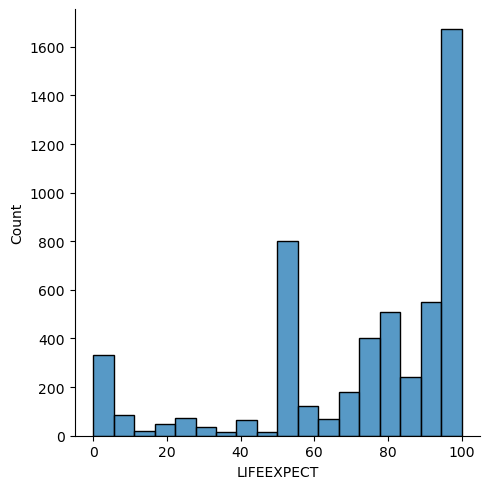

In [64]:
sns.displot(x = 'LIFEEXPECT', data = data[data['LIFEEXPECT'] != -2])

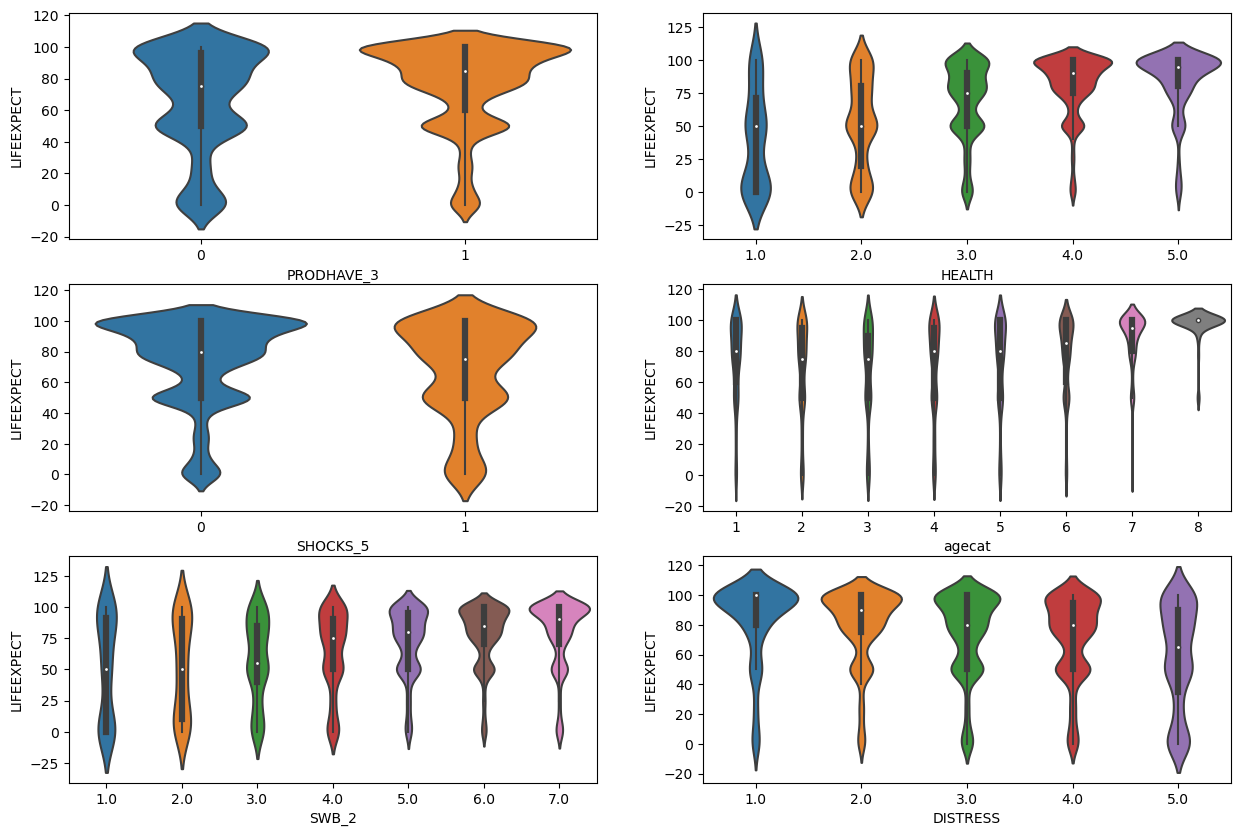

In [62]:

fig, axs = plt.subplots(3, 2, figsize=(15,10))

feats = ['PRODHAVE_3', 'HEALTH', 'SHOCKS_5', 'agecat', 'SWB_2', 'DISTRESS']

for i in range(1, 7):
    sns.violinplot(y = 'LIFEEXPECT', x = feats[i - 1], data = data[data['LIFEEXPECT'] != -2], ax = axs[(i - 1 )// 2, (i-1) % 2])
    # data.groupby(feats[i - 1])['CONNECT'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

Best variables: HEALTH, SWB_2 and DISTRESS

__KIDS_NoChildren__

Every row with missing KIDS_NoChildren has 0 in all KIDS columns


It can either mean that the person has no children or that the person did not answer the question because he/she only left the default values of 0 on all KIDS columns

In [70]:
data[data['LIFEEXPECT'].isna()].shape[0]

213

In [67]:
data.loc[data['KIDS_NoChildren'].isna(), ['KIDS_1', 'KIDS_2', 'KIDS_3', 'KIDS_4']].sum()

KIDS_1    0.0
KIDS_2    0.0
KIDS_3    0.0
KIDS_4    0.0
dtype: float64

<AxesSubplot:xlabel='KIDS_NoChildren', ylabel='count'>

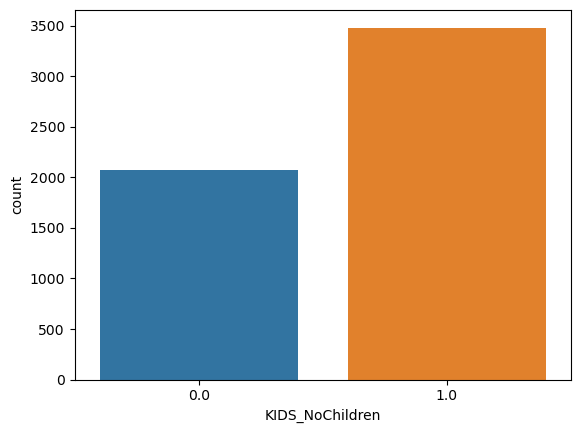

In [68]:
sns.countplot(x = 'KIDS_NoChildren', data = data)

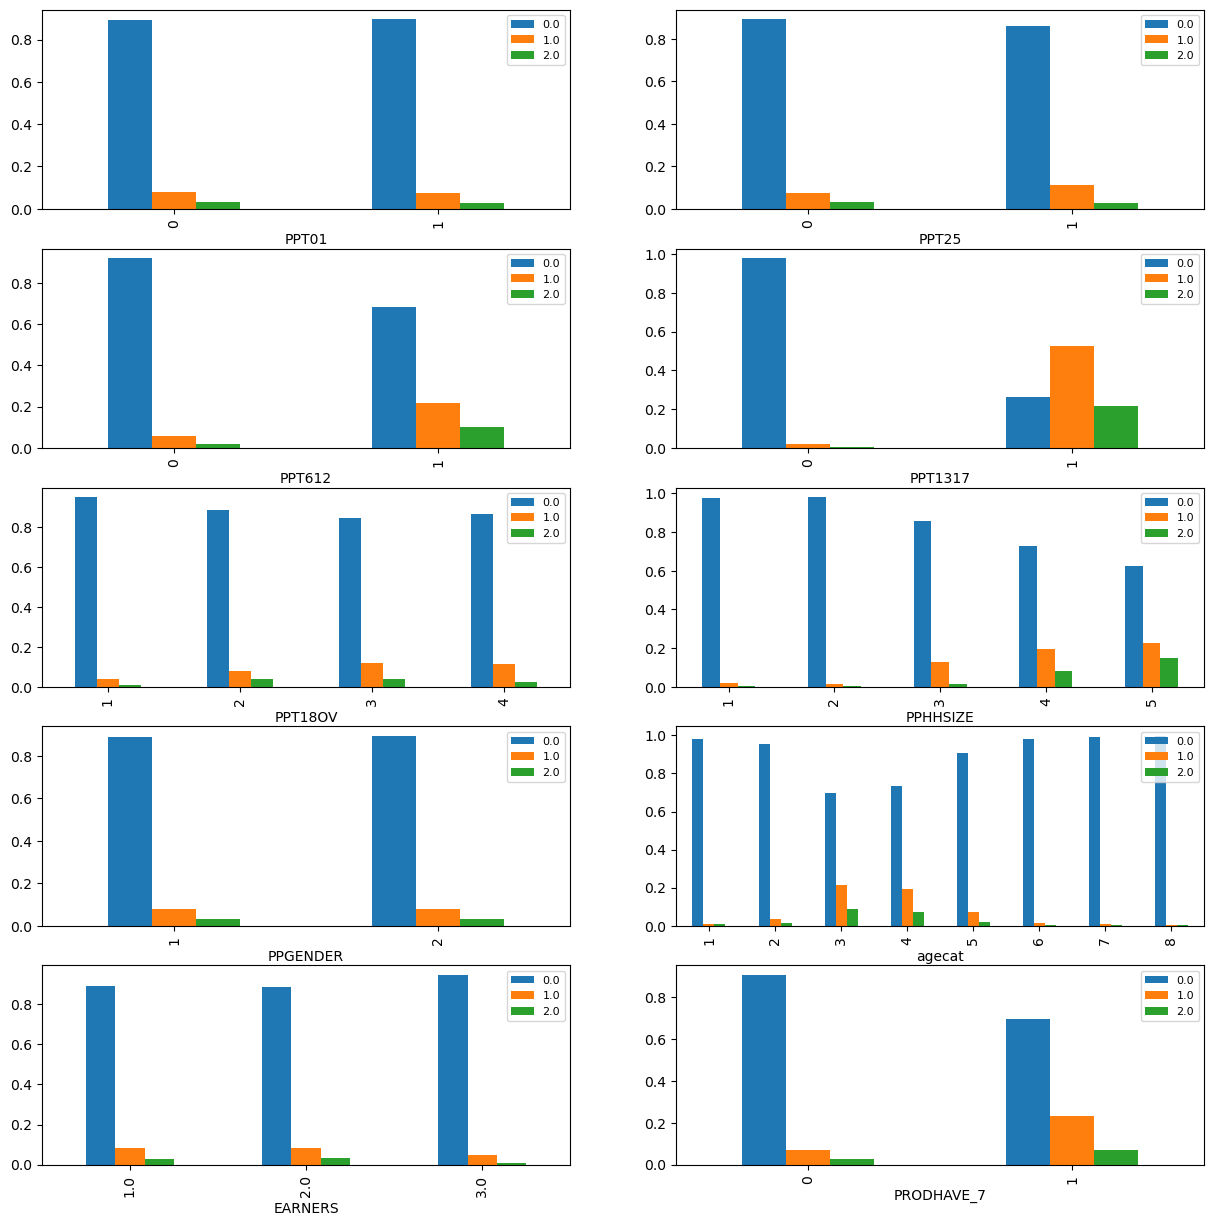

In [73]:
fig, axs = plt.subplots(5, 2, figsize=(15, 15))

feats = ['PPT01', 'PPT25', 'PPT612', 'PPT1317', 'PPT18OV', 'PPHHSIZE', 'PPGENDER', 'agecat', 'EARNERS', 'PRODHAVE_7']

for i in range(1, 11):
    data.groupby(feats[i - 1])['KIDS_3'].value_counts(normalize = True).unstack().plot.bar(ax = axs[(i - 1 )// 2, (i-1) % 2])

    # set SAVINGSRANGES legend size
    axs[(i - 1 )// 2, (i-1) % 2].legend(fontsize = 8)


# PPT01: 0-1 years old children (Yes or No)
# PPT25: 0-5 years old children (Yes or No)
# PPT612: 6-12 years old children (Yes or No)
# PPT1317: 13-17 years old children (Yes or No)
# PPT18OV: 18 years old or older children (Yes or No)

# KIDS_1: Less than 7 years old
# KIDS_2: 7-12 years old
# KIDS_3: 13-17 years old
# KIDS_4: 18 years old or older

# kids_3 e PPT1317 should be the same

# inconsistent data!!

# probably people did not understand the question, so lets exclude these variables from our analysis

## Target and Weights variables exploration

Data types:

In [50]:
data.dtypes.value_counts()

float64    103
int64       68
dtype: int64

### Weights

__Variable finalwt__: the weights included in the dataset are important for ensuring that the results obtained from the survey are representative of the United States population. These weights are used to account for variations in the probability of selection and to adjust for differential nonresponse across different socioeconomic groups.

In machine learning, when using weighted data, you can include the weights in the model training process to adjust for sampling bias. The exact method for including weights depends on the specific machine learning algorithm you are using.

For example, if you are using scikit-learn library in Python, you can use the 'sample_weight' parameter in the 'fit' method to specify the weights for each training example. Other machine learning libraries may have different methods for incorporating weights.

/home/inesmcm/miniconda3/envs/functionalenv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='finalwt', ylabel='Density'>

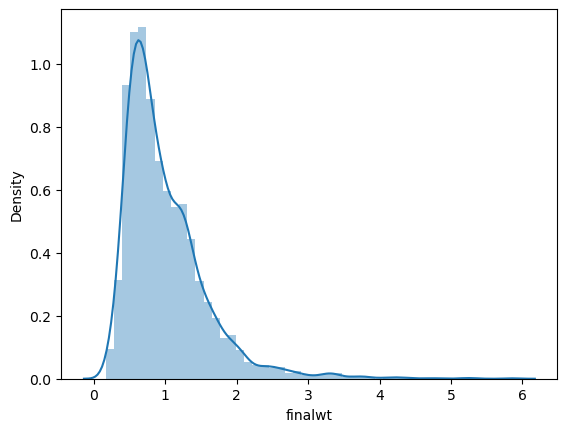

In [51]:
sns.distplot(data['finalwt'])


### Target

__Target variable__: fpl (Federal poverty level)

- <100% Federal Poverty Level
- 100-199% Federal Poverty Level
- 200%+ Federal Poverty Level

In [52]:
data.fpl.value_counts(normalize = True)

3    0.769499
2    0.131762
1    0.098739
Name: fpl, dtype: float64

The dataset is quite imbalanced

# Visualizations

Variables vs Target

Spearman correlation